# Part 0: Building the network 

To create our network, we downloaded the Zelda Wiki pages for all characters in BotW (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions!

> * Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the pages with the Zelda API.

**Answer:** 

Once the characters are extracted and stored offline, below is the strategy that was used to extract the hyperlinks:
* Read all characters into a pandas dataframe
* Use regular expressions to extract the following link types:

    a. Direct links (default): `[[name of character]]` or `{{Term|BotW|name of character|link}}`
    
    b. Links using texts: `[[Mr. character|Character]]`
    
    c. Links with paranthesis: `[[some character (Char)|]]`
    
    d. Links with plural terms: `{{Plural|Series|Heart|link}}`
    
    e. Links to sections: `[[Link#Breath of the Wild]]`
    
    
* Iterate over each character's file
* Check the text for regular expression 1 and 2, and load the results into a single set to avoid duplicated edges between characters

> * Show the regular expression(s) you have built and explain in details how it works.

**Answer:** Two regular expressions were used to capture the links for each character.

`link_pattern1` was used to handle square brackets cases `[[ ]]`

`link_pattern2` was used to handle the curly brackets cases `{{ }}`


In [1]:
link_pattern1 = r"\[\[(.*?)(?:(?:\||#).*?)?\]\]"
link_pattern2 = r"\{\{(?:Term|Plural)\|BotW\|([^{}]*?)(?:\|link)\}\}"

In [2]:
#Expression to capture the square brackets links "[[]]"
#Default case: [[name of character]]

link_pattern1 = r"""
    \[\[             #Capture the beginning of a link '[['
    (.*?)            #Capture all characters (non-greedy using '?'). This is the "link" that is stored
    (?:(?:\||#).*?)? #Detect the optional ('?' at the end) sections '#' and '|', but don't return these sections in the match by using '?:'
    \]\]             #Capture the end of a link ']]'
    """

In [3]:
#Expression to capture the curly brackets links "{{}}"
#Default case: {{Term|BotW|name of character|link}}

link_pattern2 = r"""
    \{\{              #Capture the beginning of a link '{{'
    (?:Term|Plural)   #Either a term or a plural section, which is not returned by using '?:' operator
    \|BotW\|          #BotW is captured, and the OR operater is escaped (\|) to indicate a literal character
    ([^{}]*?)         #Followed by all characters except curly brackets. Non-greedy with '?' at the end. This is the "link"
    (?:\|link)        #Capture "|link", which is not returned using the "?:" operator
    \}\}              #Capture the end of a link "}}"
    """


# Part 1: Network visualization and basic stats

Visualize the network (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you've already generated the BotW network and extracted the giant connected component. Use the GCC to report the results.


In [4]:
import re
import json
import urllib
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [5]:
#Read the characters from the csv file
df = pd.read_csv("./files/ZeldaBotW_nodes_w_attributes_enriched.csv", header=0)

In [6]:
#Construct the network. Each node is a character.
G = nx.DiGraph()
for index, row in df.iterrows():
    char,role,race,gender = row
    G.add_node(char, Role=role, Race=race, Gender=gender)

In [7]:
#Regex to retrieve the links from the files
link_pat1 = r"\[\[(.*?)(?:(?:\||#).*?)?\]\]"
link_pat2 = r"\{\{(?:Term|Plural)\|BotW\|([^{}]*?)(?:\|link)\}\}"

#Iterate over all nodes and link the nodes to each other
for node in G.nodes:
    with open("./files/zelda_chars/"+node+".txt", "r", encoding="utf-8") as f:
        node_desc = f.read()
        link1 = set(re.findall(link_pat1, node_desc))
        link2 = set(re.findall(link_pat2, node_desc))
        total_links = link1 | link2
        
        for link in total_links:
            if link in G.nodes and link != node:#Only add valid links, and discard self-references
                G.add_edge(node, link) #Form the link between the nodes

### _Exercise 1a_: Stats (see lecture 4 and 5 for more hints)

> * What is the number of nodes in the network? 

In [8]:
#Stats before discarding:
before = G.number_of_nodes()
print("Number of nodes(before discarding isolated nodes):", G.number_of_nodes())

#Discard isolated nodes:
G.remove_nodes_from(list(nx.isolates(G)))

#Stats after discarding:
print("Number of nodes(after discarding isolated nodes):", G.number_of_nodes())
print("Number of nodes discarded (isolated):", before - G.number_of_nodes())


Number of nodes(before discarding isolated nodes): 656
Number of nodes(after discarding isolated nodes): 540
Number of nodes discarded (isolated): 116


> * What is the number of links?

In [9]:
print("Number of edges:", G.number_of_edges())

Number of edges: 1597


> * Who is the top connected character in BotW? (Report results for the in-degrees and out-degrees). Comment on your findings. Is this what you would have expected?

In [10]:
in_most_connected = sorted(G.in_degree,key=lambda x:x[1], reverse=True)[0]
out_most_connected = sorted(G.out_degree,key=lambda x:x[1], reverse=True)[0]

print("Most connected character (in-degrees):", in_most_connected, "\n")
print("Most connected character (out-degrees):", out_most_connected, "\n")

Most connected character (in-degrees): ('Link', 396) 

Most connected character (out-degrees): ('Traysi', 14) 



**Answer:** Link is the most connected in-degrees character in the Wiki as expected, for he is the protoganist of the series. Many other characters are connected to him.

As for the moust out-degrees connected character, it is Traysi. She is a Hylian journalist in the game, so it is expected that she has out-connections to other characters that she is investigating or collecting information from. To further explore, we retrieve her information:

In [11]:
df.loc[df["Name"] == "Traysi"]

,Name,Role,Race,Gender
320,Traysi,Ally,Hylian,Female


In [12]:
list(G.out_edges("Traysi"))

[('Traysi', 'Strade'),
 ('Traysi', 'Ploka'),
 ('Traysi', 'Ashai'),
 ('Traysi', 'Muava'),
 ('Traysi', 'Link'),
 ('Traysi', 'Molduking'),
 ('Traysi', 'Princess Zelda'),
 ('Traysi', 'Molduga'),
 ('Traysi', 'Lyndae'),
 ('Traysi', 'King Rhoam'),
 ('Traysi', 'Riju'),
 ('Traysi', 'Dinraal'),
 ('Traysi', 'Naydra'),
 ('Traysi', 'Farosh')]

It is observed that she is connected to both enemies and allies, as a journalist is expected to be in this game's universe.

> * Who are the top 5 most connected allies (again in terms of in/out-degree)? 

In [13]:
nodes_ally = []
for name in G.nodes():
    if G.nodes[name]["Role"] == "Ally":
        nodes_ally.append(name)
        
G_Allies = G.subgraph(nodes_ally)

n=5

in_most_connected_ally = sorted(G_Allies.in_degree,key=lambda x:x[1], reverse=True)[:n]
out_most_connected_ally = sorted(G_Allies.out_degree,key=lambda x:x[1], reverse=True)[:n]

print(f"Most connected {n} allies (in):", in_most_connected_ally, "\n")
print(f"Most connected {n} allies (out):", out_most_connected_ally, "\n")

Most connected 5 allies (in): [('Link', 340), ('Hylia', 67), ('Riju', 21), ('Princess Zelda', 18), ('Mipha', 17)] 

Most connected 5 allies (out): [('Traysi', 12), ('Genli', 9), ('Greyson', 8), ('Kass', 8), ('Link', 8)] 



> * Who are the top 5 most connected enemies -- bosses included -- (again in terms of in/out-degree)?

In [14]:
nodes_enemy = []
for name in G.nodes():
    if G.nodes[name]["Role"] == "Enemy" or G.nodes[name]["Role"] == "Boss":
        nodes_enemy.append(name)

G_Enemies = G.subgraph(nodes_enemy)

n=5

in_most_connected_enemy = sorted(G_Enemies.in_degree,key=lambda x:x[1], reverse=True)[:n]
out_most_connected_enemy = sorted(G_Enemies.out_degree,key=lambda x:x[1], reverse=True)[:n]

print(f"Most connected {n} enemies (in):", in_most_connected_enemy, "\n")
print(f"Most connected {n} enemies (out):", out_most_connected_enemy, "\n")

Most connected 5 enemies (in): [('Calamity Ganon', 17), ('Bokoblin', 9), ('Lizalfos', 9), ('Stalizalfos', 8), ('Stone Talus', 8)] 

Most connected 5 enemies (out): [('Stalizalfos', 11), ('Silver Lizalfos', 10), ('Lizalfos', 10), ('Blue Lizalfos', 9), ('Ice-Breath Lizalfos', 9)] 



> * Plot the in- and out-degree distributions. 
>   * What do you observe? 
>   * Can you explain why the in-degree distribution is different from the out-degree distribution?

In [1]:
def plot_in_degree_dist(G,scale=""):
    degrees = [G.in_degree(n) for n in G.nodes()]
    plt.hist(degrees, bins=max(degrees))
    plt.title("In-Degrees Distribution")
    if scale=="log":
        plt.xscale("log")
        plt.yscale("log")
        plt.title("In-Degrees Distribution (Log-Log)")
    plt.show()

def plot_out_degree_dist(G):
    degrees = [G.out_degree(n) for n in G.nodes()]
    plt.hist(degrees, bins=max(degrees))
    plt.title("Out-Degrees Distribution")
    plt.show()

plot_in_degree_dist(G)
plot_in_degree_dist(G,scale="log")
plot_out_degree_dist(G)

NameError: name 'G' is not defined

**Answer:**

For the out-degrees, it is observed that the plot behaves more like a random network than a powerlaw one (scale-free network).  There are no extreme outliers in this case.

The in-degrees distribution is extremely skewed to the right, because major hubs have high in-degrees relative to the other characters. For instance, link has 340 in-degrees. This is expected in a network like this: there are major hubs (popular characters) for which many characters are connected to. This approaches the behavior of a scale-free network rather than a random network.

To further visulize the outliers, we use a boxplot for the in-degrees distribution:

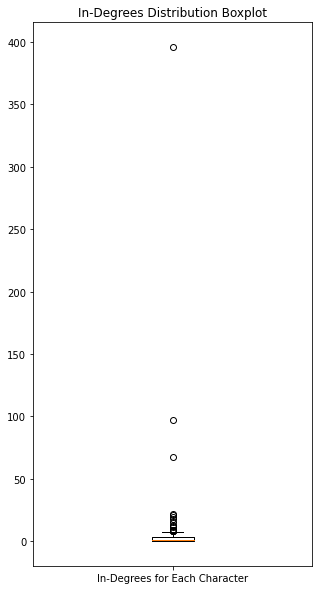

In [16]:
def plot_in_degree_dist(G):
    degrees = [G.in_degree(n) for n in G.nodes()]
    plt.figure(figsize=(5, 10))
    plt.boxplot(degrees,labels=["In-Degrees for Each Character"])
    plt.title("In-Degrees Distribution Boxplot")
    plt.show()

plot_in_degree_dist(G)

The outliers can be observed on the boxplot, with the top 3 most connected in-degrees characters dominating the plot.

> * Find the exponent of the degree distribution (by using the `powerlaw` package) for the in- and out-degree distribution. What does it say about our network?

Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Calculating best minimal value for power law fit
xmin progress: 00%
xmin progress: 08%
xmin progress: 16%
xmin progress: 25%
xmin progress: 33%
xmin progress: 41%
xmin progress: 50%
xmin progress: 58%
xmin progress: 66%
xmin progress: 75%
xmin progress: 83%


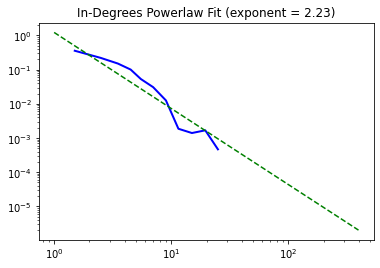

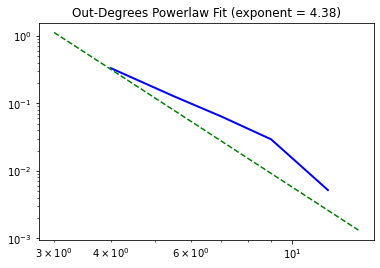

In [17]:
import powerlaw  

degrees_in =  sorted([d for n, d in G.in_degree()], reverse=True)
degrees_out = sorted([d for n, d in G.out_degree()], reverse=True)

fit_in  = powerlaw.Fit(degrees_in, xmin=1)
fit_out = powerlaw.Fit(degrees_out)

alpha_in = fit_in.alpha
alpha_out = fit_out.alpha

fig2 = fit_in.plot_pdf(color='b', linewidth=2)
plt.title(f"In-Degrees Powerlaw Fit (exponent = {alpha_in:.2f})")
fit_in.power_law.plot_pdf(color='g', linestyle='--', ax=fig2)
plt.show()

fig3 = fit_out.plot_pdf(color='b', linewidth=2)
plt.title(f"Out-Degrees Powerlaw Fit (exponent = {alpha_out:.2f})")
fit_out.power_law.plot_pdf(color='g', linestyle='--', ax=fig3)
plt.show()


**Answer:** 

The in-degree distribution can be reasonably fitted using a power law, indicating the network is relatively scale-free ($2<\gamma = 2.2<3$). This is expected due to a large number of connections to a few characters.

The out-degrees distribution cannot be reasonably fitted using a power law ($ \gamma = 4.4$), which indicates that the network behaves more like a random network than a scale-free one. [[Network Science by Albert-László Barabási]](http://networksciencebook.com/chapter/4#generating-networks)

> * Compare the degree distribution of the undirected graph to a *random network* with the same number of nodes and probability of connection *p*. Comment your results.

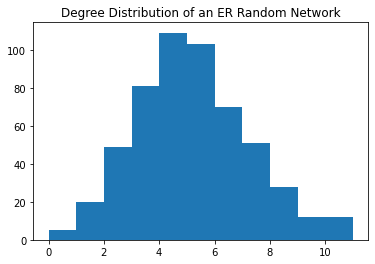

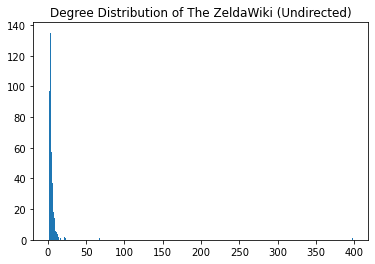

In [18]:
def plot_degree_dist(G, title=""):
    degrees = [G.degree(n) for n in G.nodes()]
    plt.hist(degrees, bins=max(degrees))
    if not title:
        plt.title("Degree Distribution")
    if title:
        plt.title(title)
    plt.show()

G2 = G.to_undirected()

# ER Construction:
N = G2.number_of_nodes()
k_ave = sum(n for _,n in G2.degree)/len(G2)
p = k_ave/(N-1)

B = nx.erdos_renyi_graph(N,p)
plot_degree_dist(B, "Degree Distribution of an ER Random Network")
plot_degree_dist(G2, "Degree Distribution of The ZeldaWiki (Undirected)")


**Answear:**

The ZeldaWiki undirected degree distribution  doesn't behave like a random network. It can be observed that the random network lacks the nodes with large links that were observed in the ZeldaWiki's network. As mentioned earlier, the ZeldaWiki's network behaves more like a scale-free network rather than a random network.


### _Exercise 1b_: Visualization (see lecture 5 for more hints)
> * Create a nice visualization of the total (undirected) network:
>   * Color nodes according to the role;

In [19]:
G2 = G.to_undirected()

#Create the array of colors based on the roles in G2
color_list = []
for node in G2.nodes(data=True):
    if node[1]["Role"] == "Ally":
        color_list.append("green")
    elif node[1]["Role"] == "Enemy":
        color_list.append("red")
    elif node[1]["Role"] == "Boss":
        color_list.append("purple")
    else:
        color_list.append("blue")

>    * Scale node-size according to degree;

In [20]:
#Create the array of sizes based on the degree in G2
size_list = [x[1]*100 for x in list(G2.degree())]

>   * Get node positions based on the Force Atlas 2 algorithm;


[[Force Atlas 2 algorithm]](https://github.com/bhargavchippada/forceatlas2)

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:29<00:00, 67.96it/s]


BarnesHut Approximation  took  4.11  seconds
Repulsion forces  took  23.34  seconds
Gravitational forces  took  0.22  seconds
Attraction forces  took  0.20  seconds
AdjustSpeedAndApplyForces step  took  0.63  seconds


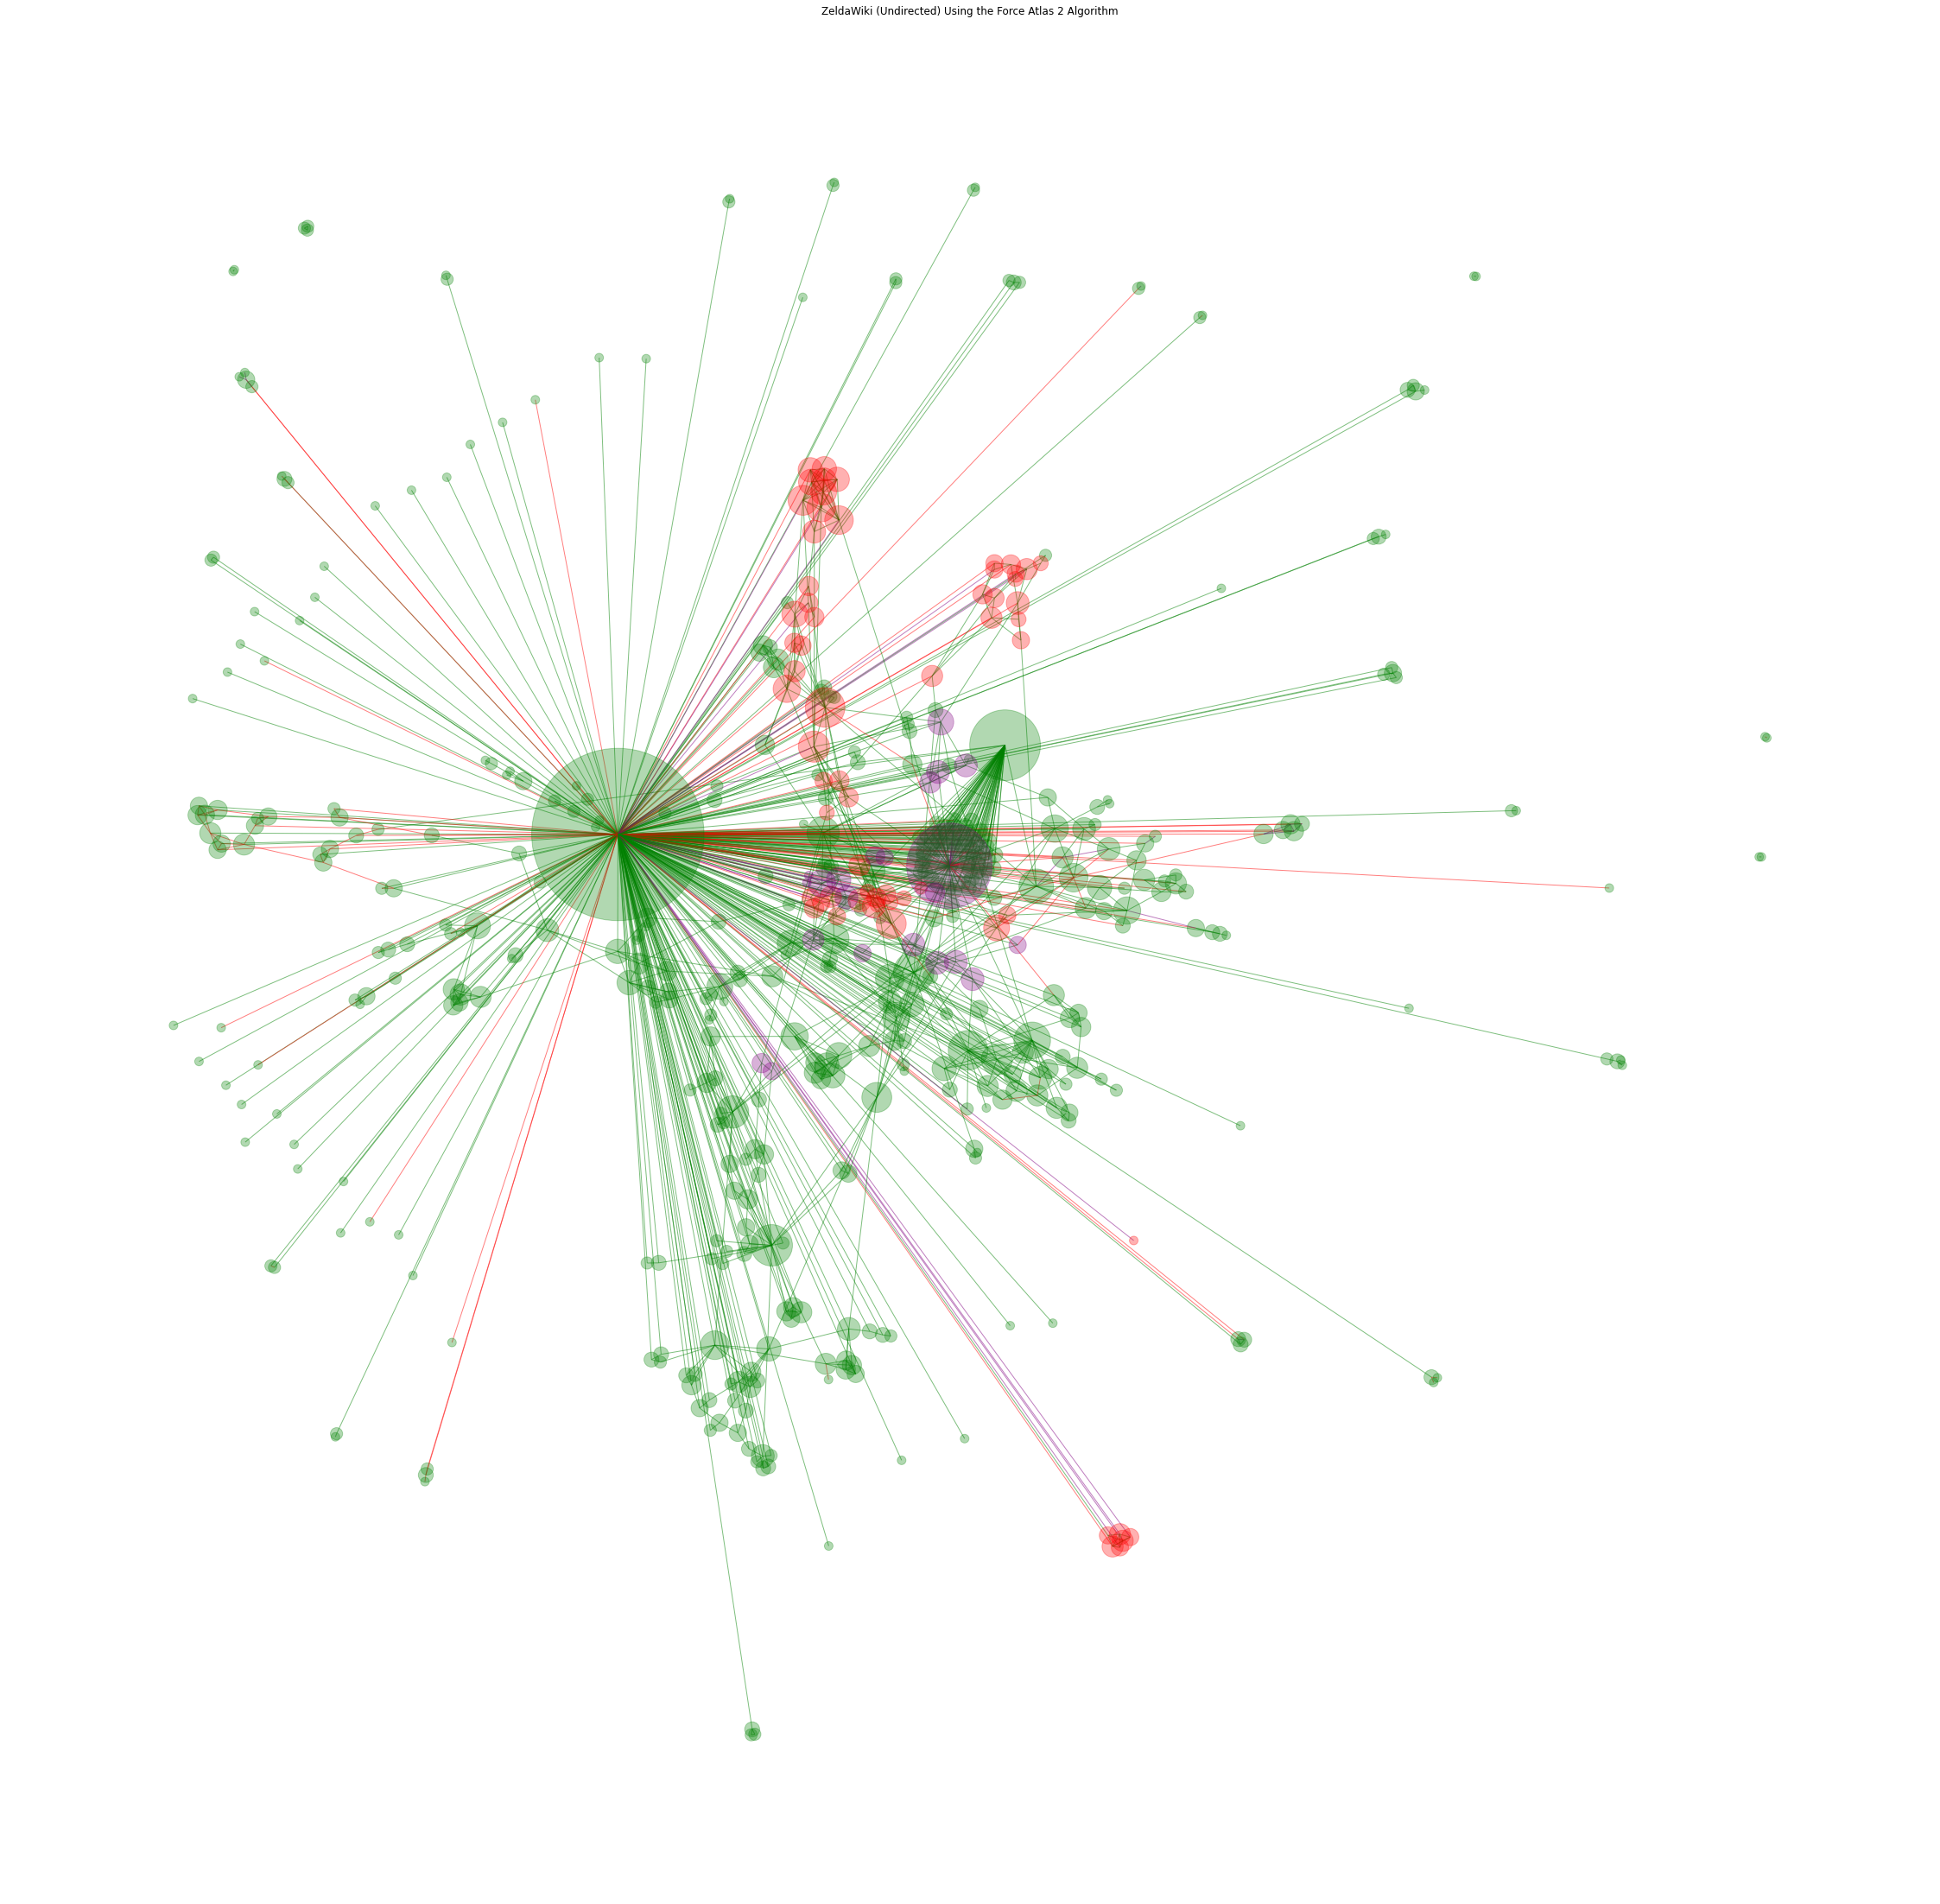

In [22]:
from fa2 import ForceAtlas2
import igraph
import matplotlib.pyplot as plt


forceatlas2 = ForceAtlas2(edgeWeightInfluence=2,  scalingRatio=2, outboundAttractionDistribution=True, strongGravityMode=False, gravity=5.0)
positions = forceatlas2.forceatlas2_networkx_layout(G2, pos=None, iterations=2000)
plt.figure(figsize=(40,40))
nx.draw_networkx_nodes(G2, positions, node_color=color_list, node_size=size_list, alpha=0.3)
nx.draw_networkx_edges(G2, positions, edge_color=color_list, alpha=0.5)
plt.title("ZeldaWiki (Undirected) Using the Force Atlas 2 Algorithm")
plt.axis('off')
plt.show()


> * Describe the structure you observe. Can you identify nodes with a privileged position in the network? Do you observe chains of connected nodes? Do you see any interesting group of nodes (can you guess who's involved)?

**Answer**:
* The network has many connections to a small number of hubs. We also observe nodes with a low number of links. Therefore, This network is behaving closer to a scale-free network than a random one.
* "Link" and "Calamity Gannon" are the biggest nodes in the network. As expected, in this story-driven universe, they are the protagonist and antagonist of the game.
* There are chains of connected nodes, especially between the allies.
* The bosses are well-connected to the game's central characters, such as "Link" and "Princess Zelda."
* It is also possible to recognize some groups of nodes highly connected to both enemies and allies.

# Part 2: Word-clouds

Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from the ZeldaWiki pages.

Here's what you need to do:
> * Create a word-cloud for each race of the [five champions of Hyrule](https://zelda.fandom.com/wiki/Champions) (i.e. Hylian, Zora, Goron, Gerudo, and Rito) according to either TC-IDF. Feel free to make it as fancy as you like. Explain your process and comment on your results.

In [24]:
import matplotlib.pyplot as plt
from collections import Counter
import math
import re
import string
import pandas as pd
import os
import wordcloud
%matplotlib inline
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)
nltk.download('wordnet',quiet=True)

True

In [25]:
#Load clean files from hdd
from nltk.corpus import PlaintextCorpusReader
import os

df_clean = pd.read_csv("./files/ ", header=0)
df_characters = df_clean.Name
path ="./files/zelda_chars_txt_lematize/"
all_files = os.listdir(path)
char_files = list(df_characters.values+".txt")
headers = df_clean.columns.values.tolist()+["Txt"]
df_clean = df_clean.reindex(columns = headers)

#Read character lem clean text into the dataframe:
for ch in df_characters:
    with open(path+ch+".txt", "r", encoding="utf-8") as fd:
        df_clean.loc[df_clean["Name"] == ch, ["Txt"]] = fd.readlines()


In [26]:
#Load text for each race into a dictionary {"race" :"full_cleaned_text"}

race_dic = {}
for char in df_clean.Name:
    race = df_clean.loc[df_clean["Name"] == char, "Race"].values[0] #Get the race of the char
    if race in race_dic: #If race exists in the dictionary, append the text
        race_dic[race] += " " + df_clean.loc[df_clean["Name"] == char, "Txt"].values[0]
    else: #Otherwise, make a new entry with the text for this race
        race_dic[race] = df_clean.loc[df_clean["Name"] == char, "Txt"].values[0]

In [27]:
#Get TF values for each word
counts_dic = {} #TC values
tf_dic = {} #Normalized TC values (TF)
races = df_clean.Race.unique()

for race in races:
    counts = Counter(race_dic[race].split()) #Count the occurance of each word per race to get TC
    counts_dic[race] = counts
    tfs = [(k,v/len(race_dic[race].split())) for k,v in counts.items()] #divide by total number of words per race to get TF
    tf_dic[race] = tfs

In [28]:
#Calculate IDF
N = len(races)
df = {}

#Get all words from the text, irrespective of race
all_words_list = (list(race_dic.values()))
all_words = set((' '.join(all_words_list)).split()) #Remove duplicated words

#Calculate DF first: Check if a word exists in each "document"
for word in all_words:
    for race in races:
        if word in race_dic[race]:
            if word in df:
                df[word]+=1 #max value = number of races = 27
            else:
                df[word]=1

idf = {k:math.log(N/(v+1)) for k,v in df.items()}
idf = dict(sorted(idf.items(), key=lambda item:item[1],reverse=True))

In [29]:
#For WordCloud, we need tc_idf
tc_idf = {}
for race in races:
    rslt = []
    for word,counts in counts_dic[race].items():
        tc_idf_word = int(round(counts*idf[word],0)) #Repeat the word by its count
        if tc_idf_word >=0:
            for i in range(tc_idf_word):
                rslt.append(word) #Add the word to a list "count" times
    tc_idf[race]=" ".join(rslt) #Convert to str for the wordcloud library

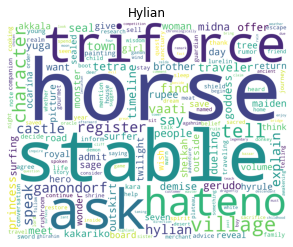

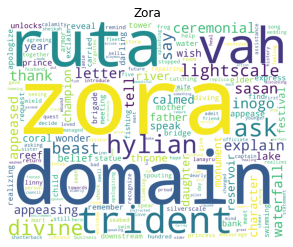

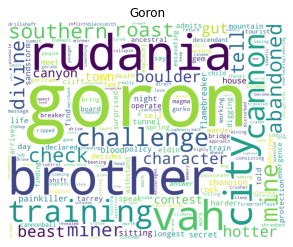

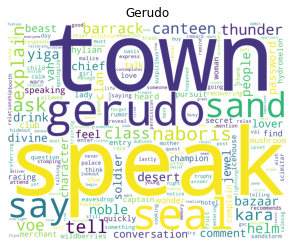

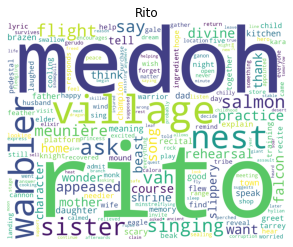

In [30]:
heros = ["Hylian", "Zora", "Goron", "Gerudo", "Rito"]
for race in heros:
    wc = wordcloud.WordCloud(
                          background_color='white',
                          width=1800,
                          height=1400,
                          collocations = False
                         ).generate(tc_idf[race])
    plt.figure()
    plt.title(race)
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

**Answer:**

The results meet our expecations for each race:
* For all races, the race itself is an important word, except Hylian
* For Hylian, the word "horse" is important, which fits with the lore of the game in which there is a strong relation between Hylians and horses
* For Goron, the word "brother" is one of the major ones, as the Gorons form a "brotherly" society in which only warrior brothers are welcomed.


# Part 3: Communities and TF-IDF

Find communities and compute their associated TF-IDF (from lecture 7 and 8).

Here's what you need to do:
> * Explain the Louvain algorithm and how it finds communities in a network.

**Answer**: 

The concept behind this method of community detection is the optimization of modularity as the algorithm progresses. Modularity measures the relative density of edges inside communities with respect to edges outside communities. Optimizing this value theoretically results in the best possible grouping of the nodes of a given network. In the Louvain Method of community detection, first small communities are found by optimizing modularity locally on all nodes, then each small community is grouped into one node, and the first step is repeated. __[Louvain Method, Fast unfolding of communities in large networks, Vincent D Blondel, Jean-Loup Guillaume, Renaud Lambiotte, Renaud Lefebvre, Journal of Statistical Mechanics: Theory and Experiment 2008(10), P10008 (12pp))__

> * Explain how you chose to identify the communities: Which algorithm did you use? (if you did not use the Louvain method, explain how the method you have used works) 

**Answer**:

The Louvain Algorithm was used.

In [33]:
import community.community_louvain as community_louvain
import networkx as nx
import matplotlib.pyplot as plt

G.remove_nodes_from(list(nx.isolates(G)))
largest_cc = max(nx.weakly_connected_components(G), key=len)
G_connected = nx.subgraph(G, largest_cc)

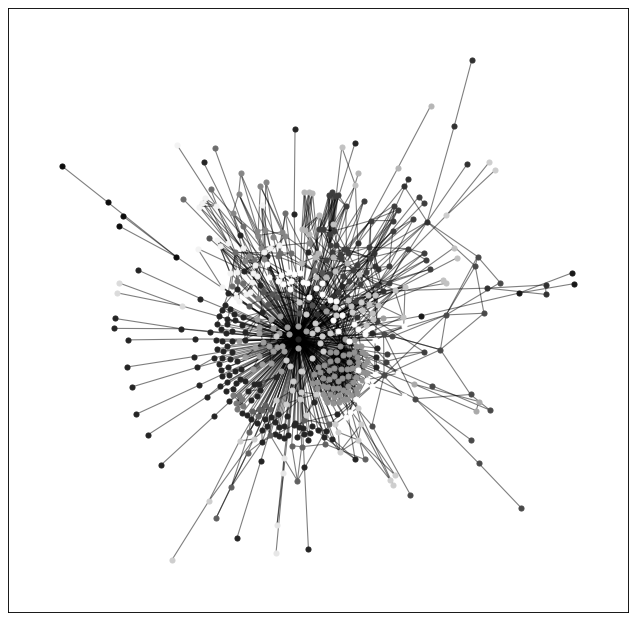

In [36]:
G = G_connected.to_undirected()

#first compute the best partition
partition = community_louvain.best_partition(G)

#drawing
size = float(len(set(partition.values())))
pos = nx.spring_layout(G)
count = 0.
plt.figure(figsize=(10, 10), dpi=80)
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20, node_color = str(count / size))

nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()

> * Comment your results:
>   * How many communities did you find in total?

In [37]:
set(partition.values())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20}

**Answer**: 

In total, 22 partitions where found.

>   * Compute the value of modularity with the partition created by the algorithm.

**Answer**:

The modularity is calculated using:
$$M = \sum\limits_{c = 1}^{n_c } {\left[ {\frac{{L_c }}{L} - \left( {\frac{{k_c }}{{2L}}} \right)^2 } \right]}  \hspace{20 mm} (9 . 12)
$$
where $L$ is the number of links in the network, $n_c$ is the number of partitions, $L_c$ is the number of links of a partition and $k_c$ is the total degree of a partition. [[Chapter 9, Network Science by Albert-László Barabási]](http://networksciencebook.com/chapter/9#modularity)

In [38]:
#Calculate the modularity for every partition, then sum all values.
M = 0
L = G.number_of_edges()
for com in set(partition.values()) :
    count = count + 1.
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    G_community = G.subgraph(list_nodes)
    Lc = G_community.number_of_edges()
    degrees = [val for (node, val) in G_community.degree()]
    kc = sum(degrees)
    M = M + (Lc/L - (kc/L)**2)

print("The Modularity is:",round(M,3))

The Modularity is: 0.504


>   * Plot the distribution of community sizes.

Community sizes: [5, 4, 124, 19, 49, 18, 11, 18, 14, 6, 17, 63, 29, 3, 16, 23, 42, 3, 4, 25, 36]


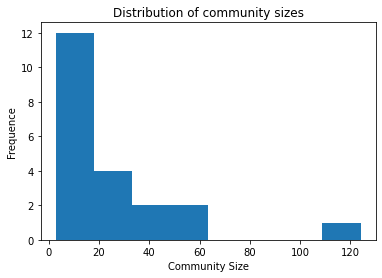

In [39]:
community_size = []
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    community_size.append(len(list_nodes))
print('Community sizes: ' + str(community_size))
plt.hist(community_size, bins='auto')
plt.title("Distribution of community sizes")
plt.xlabel("Community Size")
plt.ylabel("Frequence")
plt.show()

> * For the 5 largest communities, create TF-IDF based rankings of words in each community. 

In [40]:
#Calculate the communitites
import heapq
communities = {}
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]
    communities[com] = list_nodes
index_list_max = heapq.nlargest(5, communities, key=lambda x:len(communities[x])) # get indexes of 5 largest communities

print("Below, the 5 largest communitites are represented.\n")

for i in index_list_max:
    print(communities[i]) # -> access the nodes of the 5 biggest communities, TF-IDF can now be applied to each one of them
    print()

Below, the 5 largest communitites are represented.

['Banji', 'Cambo', 'Chork', 'Chumin', 'Ena', 'Hestu', 'Karson', 'Kenyo', 'Link', 'Mils', 'Mina', 'Misko', 'Zyle', 'Pitar', 'Nobo', 'Aliza', 'Benny', 'Haite', 'Myti', 'Trott', 'Branli', 'Konba', 'Fin', 'Gaile', 'Mayro', 'Ozunda', 'Russ', 'Chio', 'Damia', 'Daz', 'Maca', 'Natie', 'Pepp', 'Walton', 'Blynne', 'Jini', 'Loone', 'Padok', 'Roscoe', 'Calisa', 'Eighth Heroine', 'Gartan', 'Seven Heroines', 'Anche', 'Benja', 'Konora', 'Kyra', 'Pokki', 'Bozai', 'Deltan', 'Essa', 'Estan', 'Fegran', 'Frelly', 'Frita', 'Furosa', 'Greta', 'Kohm', 'Olu', 'Romah', 'Tauma', 'Emri', 'Guy', 'Kachoo', 'Maike', 'Nobiro', 'Ripp', 'Robsten', 'Shaillu', 'Vilia', 'Maypin', 'Moza', 'Piaffe', 'Pirou', 'Danton', 'Harlow', 'Ariane', 'Galli', 'Geggle', 'Lester', 'Pondo', 'Bedoli', 'Laissa', 'Mazli', 'Quince', 'Satty', 'Agus', 'Joute', 'Flavi', 'Garini', 'Dantz', 'Koyin', 'Leop', 'Manny (Breath of the Wild)', 'Prima', 'Ralera', 'Rhodes', 'Seldon', 'Sophie', 'Tamana', '

>   * There are many ways to calculate TF-IDF, explain how you've done it and motivate your choices.


In [44]:
import matplotlib.pyplot as plt
import math
import re
import string
import json
import urllib
import pandas as pd
%matplotlib inline
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from collections import Counter

>   * List the 5 top words for each community according to TF.

In [45]:
#Calculate the most common words using TF
community_dic = {}
for i in index_list_max:
    community_dic[i] = ""
    for char in communities[i]:
        community_dic[i] += " " + df_clean.loc[df_clean["Name"] == char, "Txt"].values[0]

tf_dic = {}
counts_dic = {}
top = 5
races = index_list_max

for index in index_list_max:
    counts = Counter(community_dic[index].split())
    counts_dic[index] = counts
    print('Community ', end="")
    print(index,counts.most_common(top)) #print the most common words/race
    tfs = [(k,v/len(community_dic[index].split())) for k,v in counts.items()] #divide by total words/race to get tf
    tf_dic[index] = tfs

Community 2 [('gerudo', 219), ('stable', 165), ('wild', 161), ('horse', 143), ('tell', 140)]
Community 11 [('shrine', 393), ('monk', 279), ('sheikah', 234), ('breath', 127), ('wild', 127)]
Community 4 [('attack', 78), ('found', 69), ('also', 69), ('appear', 65), ('enemy', 65)]
Community 16 [('zelda', 263), ('hyrule', 123), ('time', 112), ('sheikah', 84), ('village', 74)]
Community 20 [('gerudo', 187), ('town', 95), ('speaks', 60), ('say', 59), ('tell', 57)]


>   * List the 5 top words for each community accourding to TF-IDF. Are these words more descriptive of the community than just the TF? Justify your answer.

In [46]:
#Calculate the most common words using TF-IDF
N = len(index_list_max)
df = {}
all_words_list = (list(community_dic.values()))
all_words = set((' '.join(all_words_list)).split()) #look-up only unique words in the corpus

for word in all_words:
    for index in index_list_max:
        if word in community_dic[index]:
            if word in df:
                df[word]+=1
            else:
                df[word]=1

idf = {k:math.log(N/(v+1)) for k,v in df.items()}
idf = dict(sorted(idf.items(), key=lambda item:item[1],reverse=True))
tf_idf = {}

for index in index_list_max:
    rslt = []
    for word,tf in tf_dic[index]:
        rslt.append((word,tf*idf[word]))
    rslt.sort(key=lambda x:x[1],reverse=True)
    tf_idf[index] = rslt

#Highest 5 tf-idf values for each community
for index in tf_idf:
    print("Community ", end="")
    print(index, tf_idf[index][:top])
    print()

Community 2 [('horse', 0.0018001538890856368), ('lurelin', 0.0008787624078675752), ('gourmet', 0.0007236866888321208), ('rushrooms', 0.0007236866888321208), ('kara', 0.0006797783916826879)]

Community 11 [('monk', 0.025202537405961345), ('ostracism', 0.009883949539226075), ('activated', 0.005510232192701226), ('entered', 0.005510232192701226), ('bearing', 0.005510232192701226)]

Community 4 [('variant', 0.0034857053243463995), ('stronger', 0.002361284251976593), ('variety', 0.0015044563713810012), ('beetle', 0.001461747394080748), ('boko', 0.0012368631796067868)]

Community 16 [('timeline', 0.0018157314756542388), ('pumpkin', 0.0010168096263663737), ('fountain', 0.0009441803673402041), ('heirloom', 0.0009312768981149165), ('fortified', 0.0008715511083140346)]

Community 20 [('barrack', 0.003556338955459558), ('volume', 0.0028450711643676465), ('recovering', 0.0021338033732757346), ('thunder', 0.001905359258262222), ('allowed', 0.0009913169488957709)]



# Part 4: Sentiment of communities

Analyze the sentiment of the communities (lecture 8). Here, we assume that you've successfully identified communities.  More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below:
* We name each community by its three most connected characters.
* Average the average sentiment of the nodes in each community to find a community level sentiment.

Here's what you need to do (repeat these steps and report your results for **both LabMT and VADER**):
> * Calculate and store sentiment for every character

In [49]:
# importing the module
import json
# reading the data from the dialogue file
with open('./files/dialogues.txt') as f:
    data = f.read()      
# reconstructing the data as a dictionary
js = json.loads(data)  # js now contains the dialogues as a dict

### [LabMT](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752) 

In [50]:
import pandas as pd
df = pd.read_csv('./files/Data_Set_S1.txt', delimiter = "\t")
df.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332


In [51]:
def sentiment_calculator_LabMT(tokens):
    sumy=0
    length=0
    for token in tokens:
        if token in df['word'].values:
            sumy = sumy + float(df.happiness_average[df.word==token])
            length = length + 1
    if length == 0: # cheat, don't know why it doesn't work otherway
        return 0
    return sumy/length

In [52]:
sentiment_dict = {}
lemmatizer = WordNetLemmatizer()
for key, value in js.items():
    sumy = 0 
    length = 0
    for sentence in value:
        tokenized_sentence = lemmatizer.lemmatize(sentence)  #lemmatize the sentence
        tokenized_sentence = word_tokenize(tokenized_sentence)  # tokenize the sentence
        tokenized_sentence = [token.lower() for token in tokenized_sentence] # set to lower case the sentence
        sumy += sentiment_calculator_LabMT(tokenized_sentence)
        length +=  #calculate average of the sentences of this character
    if length != 
        sentiment_dict[key] = sumy/length 

### [Vader](http://comp.social.gatech.edu/papers/icwsm14.vader.hutto.pdf)

In [53]:
# VADER
df2 = pd.read_csv('./files/vader_lexicon.txt', delimiter = "\t", header=None)
df2.head()

,0,1,2,3
0,$:,-1.5,0.80623,"[-1, -1, -1, -1, -3, -1, -3, -1, -2, -1]"
1,%),-0.4,1.01980,"[-1, 0, -1, 0, 0, -2, -1, 2, -1, 0]"
2,%-),-1.5,1.43178,"[-2, 0, -2, -2, -1, 2, -2, -3, -2, -3]"
3,&-:,-0.4,1.42829,"[-3, -1, 0, 0, -1, -1, -1, 2, -1, 2]"
4,&:,-0.7,0.64031,"[0, -1, -1, -1, 1, -1, -1, -1, -1, -1]"


In [55]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
sentiment_dict2 = {}
lemmatizer = WordNetLemmatizer()
for key, value in js.items():
    sumy = 0 
    length = 0
    for sentence in value:
        tokenized_sentence = lemmatizer.lemmatize(sentence)  #lemmatize the sentence
        tokenized_sentence = word_tokenize(tokenized_sentence)  # tokenize the sentence
        vs = analyzer.polarity_scores(tokenized_sentence)
        sumy += vs['compound']
        length += 1 # calculate average of all the sentences of this character
    if length != 0:
        sentiment_dict2[key] = sumy/length 

> * Create a histogram of all character's associated sentiments.


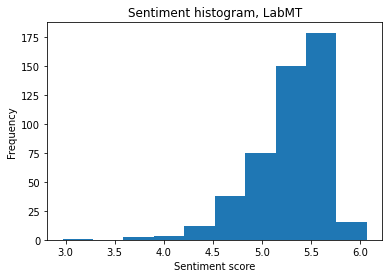

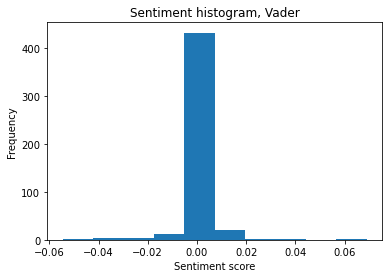

In [57]:
#sentiment_dict --> dictionary of sentiments using LabMT
#sentiment_dict2 --> dictionary of sentiments using Vader
plt.hist(sentiment_dict.values())
plt.title("Sentiment histogram, LabMT")
plt.xlabel("Sentiment score")
plt.ylabel("Frequency")
plt.show()
plt.hist(sentiment_dict2.values())
plt.title("Sentiment histogram, Vader")
plt.xlabel("Sentiment score")
plt.ylabel("Frequency")
plt.show()

> * What are the 10 characters with happiest and saddest pages?


In [58]:
print("LabMT Analysis")
print("--> The 10 character with the happiest pages are: ")
print(heapq.nlargest(10, sentiment_dict, key=sentiment_dict.get))
print("--> The 10 character with the happiest pages are: ")
print(heapq.nsmallest(10, sentiment_dict, key=sentiment_dict.get))
print()
print("Vader Analysis")
print("--> The 10 character with the happiest pages are: ")
print(heapq.nlargest(10, sentiment_dict2, key=sentiment_dict2.get))
print("--> The 10 character with the happiest pages are: ")
print(heapq.nsmallest(10, sentiment_dict2, key=sentiment_dict2.get))

LabMT Analysis
--> The 10 character with the happiest pages are: 
['Zooki', 'Tasho', 'Anly', 'Chessica', 'Katta', 'Dabi', 'Dmitri', 'Shamae', 'Kula', 'Toren']
--> The 10 character with the happiest pages are: 
['Haite', 'Olu', 'Kampo', 'Konora', 'Yunobo', 'Flavi', 'Perosa', 'Kinov', 'Wabbin', 'Onya']

Vader Analysis
--> The 10 character with the happiest pages are: 
['Karin', 'Chessica', 'Khini', 'Hagie', 'Trissa', 'Cecili', 'Gesane', 'Pelison', 'Ruli', 'Spinch (Hylian)']
--> The 10 character with the happiest pages are: 
['Cima', 'Deltan', 'Worten', 'Zuta', 'Perosa', 'Darton', 'Armes', 'Ami', 'Ollie', 'Pasha']


Now, compute the sentiment of communities: 
> * What are the three happiest communities according to the LabMT wordlist approach? What about VADER?

In [59]:
sentiment_community_LabMT = {}
sentiment_community_Vader = {}
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]     
    most_connected = heapq.nlargest(3, G.subgraph(list_nodes)) # calculate the 3 char with highest degree
    name = " ".join(most_connected)
    
    #LabMT
    sumy = 0
    length = 0
    for char in list_nodes:        #calculate average of sentiment for that community
        if char in sentiment_dict.keys():
            sumy += sentiment_dict[char]
            length += 1 
    if length != 0: # cheat, to make it works
        sentiment_community_LabMT[name] = sumy/length
    else:
        sentiment_community_LabMT[name] = 0
    
    #Vader
    sumy = 0
    length = 0
    for char in list_nodes:        #calculate average of sentiment for that community
        if char in sentiment_dict2.keys():
            sumy += sentiment_dict2[char]
            length += 1 
    if length != 0: # cheat, to make it works
        sentiment_community_Vader[name] = sumy/length
    else:
        sentiment_community_Vader[name] = 0

In [60]:
#Get the happiest communities
print("LabMT Analysis")
print("--> The 3 happiest communities are: ")
print(heapq.nlargest(3, sentiment_community_LabMT, key=sentiment_community_LabMT.get))

print()
print("Vader Analysis")
print("--> The 3 happiest communities are: ")
print(heapq.nlargest(3, sentiment_community_Vader, key=sentiment_community_Vader.get))


LabMT Analysis
--> The 3 happiest communities are: 
['Zuna Kai Ze Kasho Yowaka Ita', 'Tenne Shamae Malanya', 'Selmie Falmark Baumar']

Vader Analysis
--> The 3 happiest communities are: 
['Teebo Senna Sefaro', 'Torfeau Stone Talus (Senior) Stone Talus (Rare)', 'Rhondson Ramella Pelison']


> * What are the three saddest communities according to the LabMT wordlist approach? What about VADER?


In [61]:
#Get the saddest communities
print("LabMT Analysis")
print("--> The 3 saddest communities are: ")
print(heapq.nsmallest(3, sentiment_community_LabMT, key=sentiment_community_LabMT.get))

print()
print("Vader Analysis")
print("--> The 3 saddest communities are: ")
print(heapq.nsmallest(3, sentiment_community_Vader, key=sentiment_community_Vader.get))


LabMT Analysis
--> The 3 saddest communities are: 
['Water Octorok Treasure Octorok Snow Octorok', 'Zumi Onya Garshon', 'Yolero Izra Ami']

Vader Analysis
--> The 3 saddest communities are: 
['Yolero Izra Ami', 'Sentry Guardian Turret Guardian Stalker', 'Urbosa Traysi Teake']


> * Create a bar plot showing the average sentiment of each community and add error-bars using the standard deviation for both methods. 


In [62]:
#sentiment_community_LabMT  --> dictionary of sentiments on communities using LabMT
#sentiment_community_Vader  --> dictionary of sentiments on communities using Vader
sentiment_community_LabMT_all = {}
sentiment_community_Vader_all = {}
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == com]     
    most_connected = heapq.nlargest(3, G.subgraph(list_nodes)) # calculate the 3 char with highest degree
    name = " ".join(most_connected)
    #LabMT
    LabMT_list = []
    for char in list_nodes:        #calculate average of sentiment for that community
        if char in sentiment_dict.keys():
            LabMT_list.append(sentiment_dict[char])
            sentiment_community_LabMT_all[name] = LabMT_list
    #Vader
    Vader_list = []
    for char in list_nodes:        #calculate average of sentiment for that community
        if char in sentiment_dict2.keys():
            Vader_list.append(sentiment_dict2[char])
            sentiment_community_Vader_all[name] = Vader_list

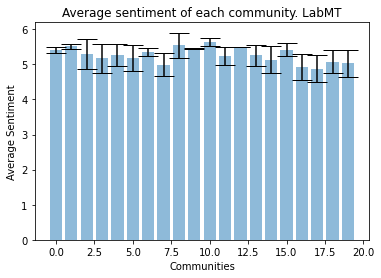

In [63]:
#LabMT          
# Create lists for the plot
communities = sentiment_community_LabMT_all.keys()
x_pos = np.arange(len(communities))
CTEs = [np.mean(x) for x in sentiment_community_LabMT_all.values()]
error = [np.std(x) for x in sentiment_community_LabMT_all.values()]

plt.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.xlabel('Communities')
plt.ylabel('Average Sentiment')
plt.title('Average sentiment of each community. LabMT')
plt.show()

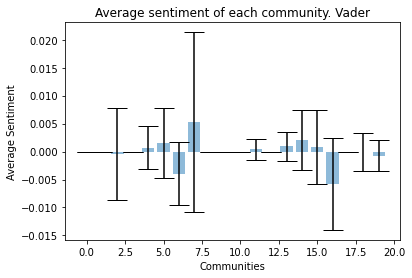

In [64]:
#Vader           
# Create lists for the plot
communities = sentiment_community_Vader_all.keys()
x_pos = np.arange(len(communities))
CTEs = [np.mean(x) for x in sentiment_community_Vader_all.values()]
error = [np.std(x) for x in sentiment_community_Vader_all.values()]

plt.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
plt.xlabel('Communities')
plt.ylabel('Average Sentiment')
plt.title('Average sentiment of each community. Vader')
plt.show()

> * Explain the difference between the two methods and compare the results you have obtained above.


**Answer**: 

The main difference is that the LabMT is a lexicon based method while the Vader is a rule based method. The LabMT uses a dictionary where words are mapped with their respective level of happiness while the Vader also contains a set of rules that can modify the score of certain words based on how these words are used in combination with others. 

The results for the LabMT show that the communities tend to have an average sentiment close to the value $5$, that is in the middle of the scale of the LabMT method. This can be interpreted as that in these communities the characters discussions tend to have a neutral sentiment on average.

For the Vader analysis, the averge values also tend to remain inside the $[-0.05, 0.05]$ interval, describing a neutral sentiment on average, but in this case the std interval shows that almost all communities have great differences in their sentiments when compared.

> * What is the advantage of using a rule-based method over the dictionary-based approach? 

**Answer**: 

A dictionary-based method does not take into account the whole sentence but only the single word, resulting in a less precise estimation of the final score, while a rule-based method can get more precise values by also considering how one word can change its meaning if used in relation with others.